In [1]:
import dynetx as dn
import networkx as nx
import pandas as pd
import itertools
from utils import autoparse_year
import matplotlib.pyplot as plt
import pickle
FOLDER_PATH = "../data/generated/graph/"

In [2]:
df_actors = pd.read_pickle('../data/generated/preprocessed/characters.pkl')

In [3]:
df_cd_actors = df_actors[df_actors.actor_age > 70].dropna(subset='fb_actor_id')
df_cd_actors

,wiki_id,fb_movie_id,release,character_name,actor_age,fb_char_id,fb_actor_id,release_year,actor_birth_year,actor_name,actor_birth,ethnicity,actor_height,actor_gender,actor_nationality
272,35412577,/m/0h19780,2011-10-21,Pete,76.0,/m/0h8n4hp,/m/02r5d3j,2011,1935,Doug McGrath,1935-08-13,NaN,NaN,M,Canada
396,20629940,/m/051zpx6,2009-01-09,NaN,71.0,/m/0cg0rcc,/m/01lntp,2009,1937,Albert Hall,1937-11-10,NaN,NaN,M,United States of America
757,30863496,/m/0gfg7zn,2011-06-11,Wataru,71.0,/m/0hzghbm,/m/0chg_3,2011,1940,Yoshio Harada,1940-02-29,NaN,NaN,M,Japan
775,22611767,/m/05zr2p5,2010,Kiku,74.0,/m/0fpvy2w,/m/05zs55n,2010,1935,Kazuko Yoshiyuki,1935-08-09,NaN,1.57,F,Japan
778,10359672,/m/02q9d9w,2007-06-02,NaN,71.0,/m/0cs329g,/m/05zs55n,2007,1935,Kazuko Yoshiyuki,1935-08-09,NaN,1.57,F,Japan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449607,5460564,/m/0dmw1x,1985,NaN,80.0,/m/0k76ld,/m/0jyyb1,1985,1905,Yûharu Atsuta,1905,NaN,NaN,M,NaN
449947,673682,/m/031t9l,1987-03-06,Toots Sweet,71.0,/m/0gcg221,/m/01htn,1987,1915,Brownie McGhee,1915-11-30,NaN,NaN,M,NaN
450056,227149,/m/01h37m,1988,NaN,74.0,/m/0jzkt7,/m/04f2k,1988,1913,Klaus Barbie,1913-10-25,NaN,NaN,M,NaN
450091,28909870,/m/0dgs88p,2010,NaN,76.0,/m/0f12r2g,/m/0f12r29,2010,1933,You Benchang,1933,NaN,NaN,M,People's Republic of China


In [4]:
# Function returns a dynamic graph elvoving according to the movies release year.
# df_actors correspond to a dataframe of actors with at least the colmuns fb_actor_id, actor_name, release 
# and fb_movie_id are present.
# lifetime is duration in years of a link between actors.
def get_dynamic_graph(df_actors):
	df_actors_temp = df_actors.copy()
	df_actors_temp['release'] = df_actors_temp.release.apply(autoparse_year).astype('Int64')
	g = dn.DynGraph()
	edges = {}
	for _, df_movie in df_actors_temp.dropna(subset=['fb_actor_id', 'release']).groupby('fb_movie_id'):
		df_movie.drop_duplicates(subset="fb_actor_id", inplace=True)
		if not df_movie.release.iloc[0] in edges:
			edges[df_movie.release.iloc[0]] = []
		edges[df_movie.release.iloc[0]] += itertools.combinations(df_movie.actor_name, r=2)
	start_year = min(edges.keys())
	stop_year = max(edges.keys())
	for key in sorted(edges.keys()):
		if len(edges[key]) > 0:
			g.add_interactions_from(edges[key], t=key-start_year)
	del df_actors_temp
	return g, start_year, stop_year

def save_dynamic_graph(graph, path):
	f = open(path, "wb")
	pickle.dump(graph, f)
	f.close()

def load_dynamic_graph(path):
	f = open(path, "rb")
	graph = pickle.load(f)
	f.close()
	return graph

In [5]:
g, start_year, stop_year = get_dynamic_graph(df_cd_actors)

In [6]:
# save dynamic graph
save_dynamic_graph(g, FOLDER_PATH + "actor_graph_dyn_uk")

In [7]:
# read dynamic graph
g = load_dynamic_graph(FOLDER_PATH + "actor_graph_dyn_uk")

In [8]:
def get_network_pos(t_from, t_to):
    s = g.time_slice(t_from=t_from, t_to=t_to)
    if len(s) == 0:
        return 0, 0
    pos = nx.kamada_kawai_layout(
        s
    )
    pos = nx.spring_layout(
        s,
        pos=pos,
        iterations=1000,
        threshold=0,
        k=30,
    )
    return (s, pos)

def plot_dynamic_graph(graph, start_year, stop_year, step):
    assert step <= stop_year - start_year
    columns = 2
    rows = int((stop_year - start_year) / (step * columns))
    assert rows >= 2
    fig, ax = plt.subplots(rows, columns, figsize=(15,60))
    for i in range(rows):
        for j in range(columns):
            t_from = (i * columns + j) * step
            graph, pos = get_network_pos(t_from, t_from + step)
            if graph != 0:
                nx.draw_networkx(graph, ax=ax[i, j], pos=pos, node_color='blue', edge_color='gray')
                ax[i, j].set_title(t_from + start_year)


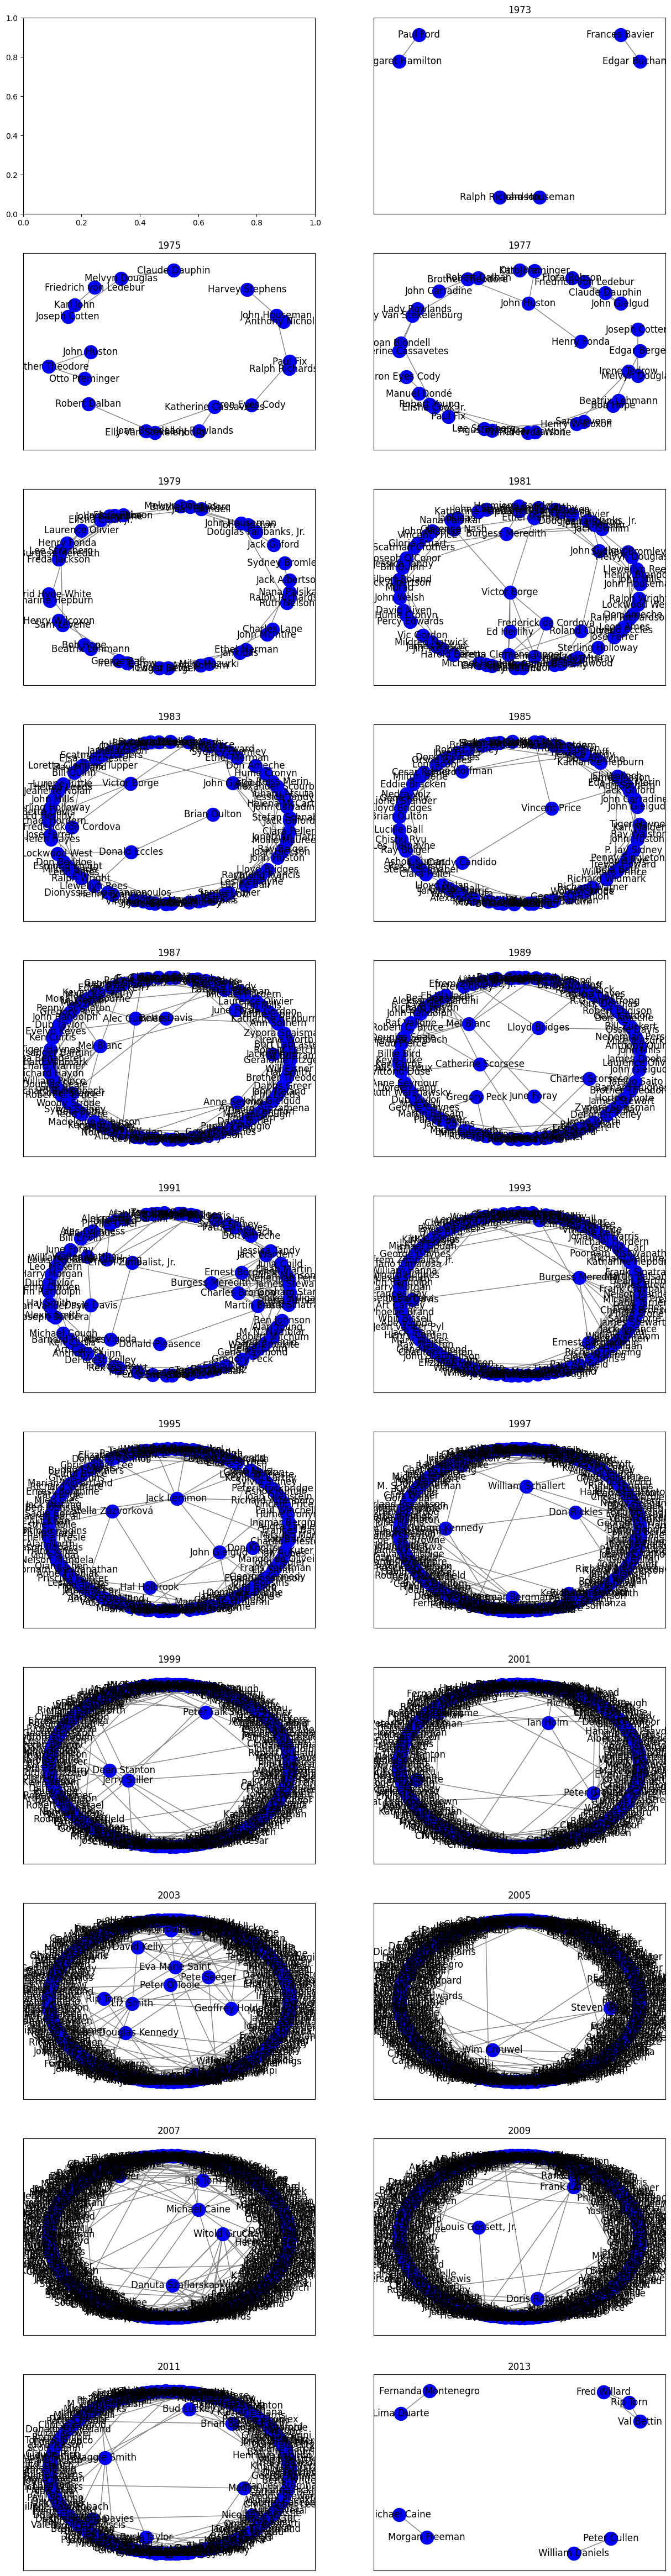

In [9]:
plot_dynamic_graph(g, start_year, stop_year, 2) # put a small step size